# Tutorial VI: Recurrent Neural Networks

<p>
Bern Winter School on Machine Learning, 2021<br>
Prepared by Mykhailo Vladymyrov.
</p>

This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

In this session we will see what RNN is. We will use it to predict/generate text sequence, but same approach can be applied to any sequential data.


So far we looked at the data available altogether. In many cases the data is sequential (weather, speach, sensor signals etc).
RNNs are specifically designed for such tasks.

<img src="https://github.com/neworldemancer/BMLWS/raw/main/figures/rnn.png" alt="drawing" width="90%"/><br>



## 1. Load necessary libraries

In [1]:
colab = True # set to True is using google colab

In [2]:
if colab:
    %tensorflow_version 2.x

In [3]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipyd
import tensorflow as tf
import collections
import time

from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 5px;
    color: #0000aa;
    background-color: #cccccc;
} </style>""")

%load_ext tensorboard

from google.colab import files

## unpack libraries
if using colab, run the next cell

In [4]:
if colab:
    p = tf.keras.utils.get_file('./material.tgz', 'https://github.com/neworldemancer/BMLWS/raw/main/tut_files/tpub0320.tgz')
    !mv {p} .
    !tar -xvzf material.tgz > /dev/null 2>&1

81215488/81207979 [==============================] - 1s 0us/step


In [5]:
from utils import gr_disp

In [6]:
def show_graph(g=None, gd=None):
    gr_disp.show_graph_eager(g, gd)
    %tensorboard --logdir logs

## 2. Load the convered midi data

In [7]:
training_datasets = []
for i in range(26):
  training_file = f'RNN/{i:03d}.npy'
  training_data = np.load(training_file)
  training_datasets.append(training_data)

In [8]:
training_data = training_datasets[0]

In [9]:
print(training_data[:100])

[[0.         1.         0.         ... 0.         0.5078125  0.        ]
 [1.         0.         0.         ... 0.         0.5078125  0.01171875]
 [0.         1.         0.         ... 0.         0.5078125  0.36328125]
 ...
 [0.         1.         0.         ... 0.         0.640625   0.        ]
 [0.         1.         0.         ... 0.         0.6875     0.        ]
 [1.         0.         0.         ... 0.         0.640625   0.046875  ]]


In [10]:
n_pars = training_data.shape[1]

In [11]:
n_pars

132

## 4. Build model

We will build the model in TF2.
It will contain an embedding layer, and three LSTM layers.
Dense layer on top is used to output probability of the next word:

In [12]:
class MidiNet:
  n_hidden = [256, 512, 128]
  n_input = 512  # word sequence to predict the following word

  @staticmethod
  def common_branch(inputs):
    #print(inputs)

    x = tf.keras.layers.Dense(32, activation='relu', name='embedding')(inputs)
    #print(x)
    for i, n_h in enumerate(MidiNet.n_hidden):
        x = LSTM(n_h, return_sequences=True, name=f'l_{i}_lstm{n_h}')(x)

    x = tf.keras.layers.Dense(64, activation='relu', name='features')(x)
    return x

  @staticmethod
  def onoff_head(features):
    x = Dense(2, name='onoff_head')(features)
    x = Activation('softmax', name="onoff")(x)
    return x

  @staticmethod
  def note_head(features):
    x = Dense(128, name='note_head')(features)
    x = Activation('softmax', name="note")(x)
    return x

  @staticmethod
  def vel_head(features):
    x = Dense(1, name='vel_head')(features)
    x = Activation('sigmoid', name="vel")(x)
    return x

  @staticmethod
  def time_head(features):
    x = Dense(1, name='time_head')(features)
    x = Activation('sigmoid', name="time")(x)
    return x

  @staticmethod
  def build(n_pars):
    inputShape = (None, n_pars)  # MidiNet.n_input
    inputs = Input(shape=inputShape, name='input')
    
    features = MidiNet.common_branch(inputs)
    
    onoff = MidiNet.onoff_head(features)
    note = MidiNet.note_head(features)
    vel = MidiNet.vel_head(features)
    time = MidiNet.time_head(features)

    model = Model(
        inputs=inputs,
        outputs=[onoff, note, vel, time],
        name="midinet")

    return model

In [13]:
# initialize our FashionNet multi-output network
model = MidiNet.build(n_pars)

# define two dictionaries: one that specifies the loss method for
# each output of the network along with a second dictionary that
# specifies the weight per loss
losses = {
	"onoff": "categorical_crossentropy",
	"note": "categorical_crossentropy",
	"vel": "mse",
	"time": "mse",
}

lossWeights = {
	"onoff": 1.,
	"note": 1.,
	"vel": 1.,
	"time": 1000.,
}
# initialize the optimizer and compile the model
print("[INFO] compiling model...")
opt = tf.keras.optimizers.RMSprop()
model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,
	metrics=["accuracy"])
W0 = model.get_weights()

model.summary()

[INFO] compiling model...
Model: "midinet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 132)]  0                                            
__________________________________________________________________________________________________
embedding (Dense)               (None, None, 32)     4256        input[0][0]                      
__________________________________________________________________________________________________
l_0_lstm256 (LSTM)              (None, None, 256)    295936      embedding[0][0]                  
__________________________________________________________________________________________________
l_1_lstm512 (LSTM)              (None, None, 512)    1574912     l_0_lstm256[0][0]                
__________________________________________________________________

In [14]:
model.load_weights('trained_midi_512.h5')

## 5. Data streaming

Here we will see how to feed a dataset for model training:

In [15]:
training_data.shape

(10590, 132)

In [16]:
def gen_sample():
  sz_smpl = MidiNet.n_input + 1
  sz_all = len(training_data)

  sz_starts = sz_all - sz_smpl

  n_samples = int(np.ceil(sz_all/sz_smpl))
  print(f'n_samples ={n_samples}')

  for i in range(n_samples):
    ofs = np.random.randint(0, high=sz_starts)
    sample = training_data[ofs:ofs+sz_smpl]
    yield sample

In [17]:
def gen_sample_mult():
  n_ds = len(training_datasets)

  info = {}
  for i, training_data in enumerate(training_datasets):
    sz_smpl = MidiNet.n_input + 1
    sz_all = len(training_data)

    sz_starts = sz_all - sz_smpl

    n_samples = int(np.ceil(sz_all/sz_smpl))
  

    info[i] = [n_samples, sz_starts]

  n_samples = np.sum([n for n,sz in info.values()])

  print(f'n_samples ={n_samples}')

  for i in range(n_samples):
    while True:
      ds_idx = np.random.randint(0, high=n_ds)
      if info[ds_idx][0] > 0:
        info[ds_idx][0] -= 1 
        break

    training_data = training_datasets[ds_idx]
    ofs = np.random.randint(0, high=info[ds_idx][1])
    sample = training_data[ofs:ofs+sz_smpl]
    yield sample

In [18]:
# create tf.data.Dataset object
#samples_dataset = tf.data.Dataset.from_tensor_slices(training_data)

In [19]:
# take metod generates elements:
#for i in samples_dataset.take(5):
#  print(i.shape)

The `batch` method creates dataset, that generates sequences of elements:

In [20]:
#sequences = samples_dataset.batch(MidiNet.n_input+1, drop_remainder=True)

In [21]:
#sequences = tf.data.Dataset.from_generator(gen_sample, 
#                                           output_signature=(tf.TensorSpec(shape=(MidiNet.n_input + 1, n_pars), dtype=tf.float32))
#                                           )

In [22]:
sequences = tf.data.Dataset.from_generator(gen_sample_mult, 
                                           output_signature=(tf.TensorSpec(shape=(MidiNet.n_input + 1, n_pars), dtype=tf.float32))
                                           )

In [23]:
for item in sequences.take(5):
  print(item.shape)

n_samples =168
(513, 132)
(513, 132)
(513, 132)
(513, 132)
(513, 132)


 The `map` method allows to use any function to preprocess the data:

In [24]:
def split_input_target(chunk):
    input_data = chunk[:-1]
    target_all = chunk[1:]

    target_data = {
      "onoff": target_all[..., :2],
      "note": target_all[..., 2:-2],
      "vel": target_all[..., -2:-1],
      "time": target_all[..., -1:],
    }

    return input_data, target_data

dataset = sequences.map(split_input_target)

The model will predict input_text -> target_text:

In [25]:
for input_example, target_example in  dataset.take(1):
  print ('Input data: ', input_example.shape)
  for k, v in target_example.items():
    print (f'Target data {k}:', v.shape)

n_samples =168
Input data:  (512, 132)
Target data onoff: (512, 2)
Target data note: (512, 128)
Target data vel: (512, 1)
Target data time: (512, 1)


Finally we will shuffle the items, and produce minibatches of 16 elements:

In [26]:
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True)
dataset

<BatchDataset shapes: ((16, 512, 132), {onoff: (16, 512, 2), note: (16, 512, 128), vel: (16, 512, 1), time: (16, 512, 1)}), types: (tf.float32, {onoff: tf.float32, note: tf.float32, vel: tf.float32, time: tf.float32})>

Let's test not trained model:

In [27]:
def concat_pred(pred_tf):
  return np.concatenate([v.numpy() for v in pred_tf], axis = -1)

In [28]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  example_batch_predictions = concat_pred(example_batch_predictions)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vector size)")

n_samples =168
(16, 512, 132) # (batch_size, sequence_length, vector size)


In [29]:
#print('input: ', to_text(input_example_batch.numpy()[0]))
#print('output:', to_text(target_example_batch.numpy()[0]))
#print('pred:  ', to_text(example_batch_predictions.numpy()[0].argmax(axis=1)))


## 5. Train!

In [ ]:
%tensorboard --logdir logs/fit

In [30]:
#model.set_weights(W0)


logdir="logs/fit/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
history = model.fit(dataset, epochs=int(1024*2.5), verbose=1, callbacks=[tensorboard_callback])

model.save(f'trained_midi_{MidiNet.n_input}.h5', save_format="h5")


Streaming output truncated to the last 5000 lines.
n_samples =168
10/10 [==============================] - 1s 114ms/step - loss: 7.5824 - onoff_loss: 0.6941 - note_loss: 4.0310 - vel_loss: 0.0226 - time_loss: 0.0028 - onoff_accuracy: 0.4998 - note_accuracy: 0.0351 - vel_accuracy: 0.0000e+00 - time_accuracy: 0.1838
Epoch 14/2560
n_samples =168
10/10 [==============================] - 1s 113ms/step - loss: 8.5715 - onoff_loss: 0.6936 - note_loss: 4.0221 - vel_loss: 0.0245 - time_loss: 0.0038 - onoff_accuracy: 0.4992 - note_accuracy: 0.0359 - vel_accuracy: 0.0000e+00 - time_accuracy: 0.1875
Epoch 15/2560
n_samples =168
10/10 [==============================] - 1s 114ms/step - loss: 8.1617 - onoff_loss: 0.6934 - note_loss: 3.9991 - vel_loss: 0.0216 - time_loss: 0.0034 - onoff_accuracy: 0.4998 - note_accuracy: 0.0341 - vel_accuracy: 0.0000e+00 - time_accuracy: 0.1534
Epoch 16/2560
n_samples =168
10/10 [==============================] - 1s 114ms/step - loss: 8.2460 - onoff_loss: 0.6936 - note

KeyboardInterrupt: ignored

In [31]:
model.save(f'trained_midi_{MidiNet.n_input}.h5', save_format="h5")

In [36]:
history = model.history

In [37]:
history.history.keys()

dict_keys(['loss', 'onoff_loss', 'note_loss', 'vel_loss', 'time_loss', 'onoff_accuracy', 'note_accuracy', 'vel_accuracy', 'time_accuracy'])

In [38]:
def draw_history(hist):
  fig, axs = plt.subplots(1, 2, figsize=(10,5))
  axs[0].plot(hist.epoch, hist.history['loss'])
  axs[0].plot(hist.epoch, hist.history['onoff_loss'])
  axs[0].plot(hist.epoch, hist.history['note_loss'])
  axs[0].plot(hist.epoch, hist.history['vel_loss'])
  axs[0].plot(hist.epoch, hist.history['time_loss'])
  
  if 'val_loss' in hist.history:
    axs[0].plot(hist.epoch, hist.history['val_loss'])
  axs[0].legend(('training loss', 'validation loss'))
  axs[1].plot(hist.epoch, hist.history['onoff_accuracy'])
  axs[1].plot(hist.epoch, hist.history['note_accuracy'])
  axs[1].plot(hist.epoch, hist.history['vel_accuracy'])
  axs[1].plot(hist.epoch, hist.history['time_accuracy'])
  if 'val_accuracy' in hist.history:
    axs[1].plot(hist.epoch, hist.history['val_accuracy'])

  axs[1].legend(('training accuracy', 'validation accuracy'))
  plt.show()

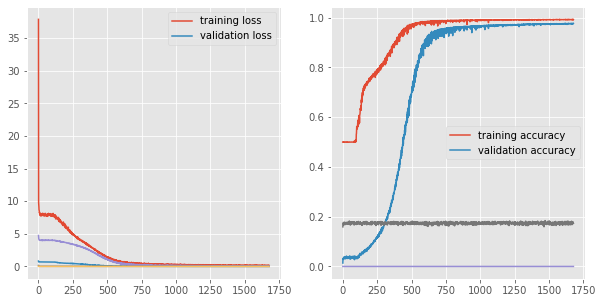

In [39]:
draw_history(history)

## 6. Generating text with RNN

Take word sequence and generate the following 128 words:

In [29]:
MidiNet.n_input, n_pars

(512, 132)

In [30]:
def gen_long(model, in_seq, n_smpl=4096):
  out = list(in_seq.copy())
  for i in range(n_smpl):
      print(f'{i}/{n_smpl}')
      keys = np.array(out[-MidiNet.n_input:])[np.newaxis]
      #print(keys.shape)

      pred_tf = model(keys)
      pred = concat_pred(pred_tf)
      #print(pred.shape)
      
      pred_next = pred[0, -1, :]
      #print(pred_next.shape)

      out.append(pred_next)
    
  return out

In [31]:
def gen_long_inf(model, in_seq, n_smpl=4096):
  out = list(in_seq.copy())
  for i in range(n_smpl):
      print(f'{i}/{n_smpl}')
      keys = np.array(out)[np.newaxis]
      #print(keys.shape)

      pred_tf = model(keys)
      pred = concat_pred(pred_tf)
      #print(pred.shape)
      
      pred_next = pred[0, -1, :]
      #print(pred_next.shape)

      out.append(pred_next)
    
  return out

In [32]:
input_example_batch.shape

TensorShape([16, 512, 132])

In [43]:
seqs = []
for input_example_batch, target_example_batch in dataset.take(1):
  input_seq_n = input_example_batch.numpy()
  for i, input_seq in enumerate(input_seq_n): # 1 sample
    print(f'\n\nsample {i}:')
    out_seq = gen_long(model, input_seq)
    seqs.append(out_seq)
    if i>=5:
      break

Streaming output truncated to the last 5000 lines.
3195/4096
3196/4096
3197/4096
3198/4096
3199/4096
3200/4096
3201/4096
3202/4096
3203/4096
3204/4096
3205/4096
3206/4096
3207/4096
3208/4096
3209/4096
3210/4096
3211/4096
3212/4096
3213/4096
3214/4096
3215/4096
3216/4096
3217/4096
3218/4096
3219/4096
3220/4096
3221/4096
3222/4096
3223/4096
3224/4096
3225/4096
3226/4096
3227/4096
3228/4096
3229/4096
3230/4096
3231/4096
3232/4096
3233/4096
3234/4096
3235/4096
3236/4096
3237/4096
3238/4096
3239/4096
3240/4096
3241/4096
3242/4096
3243/4096
3244/4096
3245/4096
3246/4096
3247/4096
3248/4096
3249/4096
3250/4096
3251/4096
3252/4096
3253/4096
3254/4096
3255/4096
3256/4096
3257/4096
3258/4096
3259/4096
3260/4096
3261/4096
3262/4096
3263/4096
3264/4096
3265/4096
3266/4096
3267/4096
3268/4096
3269/4096
3270/4096
3271/4096
3272/4096
3273/4096
3274/4096
3275/4096
3276/4096
3277/4096
3278/4096
3279/4096
3280/4096
3281/4096
3282/4096
3283/4096
3284/4096
3285/4096
3286/4096
3287/4096
3288/4096
3289/4096

In [ ]:
seqs = []
for input_example_batch, target_example_batch in dataset.take(1):
  input_seq_n = input_example_batch.numpy()
  for i, input_seq in enumerate(input_seq_n): # 1 sample
    print(f'\n\nsample {i}:')
    out_seq = gen_long_inf(model, input_seq)
    seqs.append(out_seq)
    if i>=1:
      break

Streaming output truncated to the last 5000 lines.
2673/4096
2674/4096
2675/4096
2676/4096
2677/4096
2678/4096
2679/4096
2680/4096
2681/4096
2682/4096
2683/4096
2684/4096
2685/4096
2686/4096
2687/4096
2688/4096
2689/4096
2690/4096
2691/4096
2692/4096
2693/4096
2694/4096
2695/4096
2696/4096
2697/4096
2698/4096
2699/4096
2700/4096
2701/4096
2702/4096
2703/4096
2704/4096
2705/4096
2706/4096
2707/4096
2708/4096
2709/4096
2710/4096
2711/4096
2712/4096
2713/4096
2714/4096
2715/4096
2716/4096
2717/4096
2718/4096
2719/4096
2720/4096
2721/4096
2722/4096
2723/4096
2724/4096
2725/4096
2726/4096
2727/4096
2728/4096
2729/4096
2730/4096
2731/4096
2732/4096
2733/4096
2734/4096
2735/4096
2736/4096
2737/4096
2738/4096
2739/4096
2740/4096
2741/4096
2742/4096
2743/4096
2744/4096
2745/4096
2746/4096
2747/4096
2748/4096
2749/4096
2750/4096
2751/4096
2752/4096
2753/4096
2754/4096
2755/4096
2756/4096
2757/4096
2758/4096
2759/4096
2760/4096
2761/4096
2762/4096
2763/4096
2764/4096
2765/4096
2766/4096
2767/4096

In [ ]:
seqs = np.array(seqs)
print(seqs.shape)

In [ ]:
samples_name = f'{len(seqs)}_samples_i.npy'
np.save(samples_name, seqs)

In [ ]:
print(seqs.shape)

In [ ]:
files.download(samples_name)

In [48]:
files.download('trained_midi_512.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Or try to input some text and see continuation:

In [ ]:
while True:
    prompt = "%s words: " % n_input

    try:
      sentence = input(prompt)
    except KeyboardInterrupt:
      break

    sentence = sentence.strip()
    words = sentence.split(' ')
    if len(words) != n_input:
        continue
    try:
        symbols_in_keys = [dictionary[str(words[i])] for i in range(len(words))]
    except:
        print("Word not in dictionary")
        continue

    sentence = gen_long(model, symbols_in_keys)
    print(sentence)


## 7. Excercice 


* Run with 5-7 input words instead of 3.
* increase number of training iterations, since convergance will take much longer (training as well!).

## 8. Further reading

[Illustrated Guide to Recurrent Neural Networks](https://towardsdatascience.com/illustrated-guide-to-recurrent-neural-networks-79e5eb8049c9)

[Illustrated Guide to LSTM’s and GRU’s: A step by step explanation](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)